## SAGA Paper 4, FIGURE 7: Radial Histograms

In [1]:
import numpy as np
from myplotstyle import plt,get_figsize

%matplotlib inline

from scipy import stats
import matplotlib.lines as mlines

import matplotlib
import matplotlib.backends.backend_pdf
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import norm
from SAGA.utils import calc_cdf

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

In [2]:
saga = SAGA.QuickStart()

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
# GET ALL GALAXIES
base   = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

sats = C.is_sat.filter(base)

In [4]:
base = saga.host_catalog.construct_host_query("paper3").filter(saga.object_catalog.load_combined_base_catalog())

In [5]:
def my_mean(x,xerr):

    m=np.isfinite(x)
    sum1 = np.sum(x[m]/xerr[m]**2)
    sum2 = np.sum(1./xerr[m]**2)

    mean = sum1/sum2
    err  = np.sqrt(1./sum2)

    return mean, err

In [6]:
rng = np.random.default_rng(1234)

def faster_bootstrap(sats, rbins):
    n_sat_f = sats["p_sat_corrected"].sum()
    p_sat = sats["p_sat_corrected"] / n_sat_f
    n_sat = int(n_sat_f)
    n_sat_f -= n_sat
    n_boot = 5000
    radial_boot = []
    for i in range(n_boot):
        n_sat_this = (n_sat + 1) if i >= n_boot * n_sat_f else n_sat
        radial_boot.append(calc_cdf(rng.choice(sats['RHOST_KPC'], size=n_sat_this, p=p_sat), rbins))
    return np.quantile(radial_boot, norm.sf([1, -1]), axis=0)


In [7]:
def find_half_radius(rbins, r_plain,radial_boot16, radial_boot84):

    mn = np.argmin(np.abs(r_plain - 0.5))
    mn16 = np.argmin(np.abs(radial_boot16 - 0.5))
    mn84 = np.argmin(np.abs(radial_boot84 - 0.5))


    return rbins[mn],rbins[mn16],rbins[mn84]

In [8]:
star_forming_selector = Query("quenched_phony == 0")
quenched_selector     = Query("quenched_phony == 1")

In [9]:
rbins = np.linspace(10, 300, 7)
xd    = 0.5 * (rbins[1:] + rbins[:-1])

In [10]:
def bin_wmean(bins,x,y,yerr):

    wmean,werr1, werr2 = [],[],[]

    for i,b in enumerate(bins[:-1]):
        m = (x>bins[i]) & (x<bins[i+1])

        xx = np.nanpercentile(y[m], [16, 50, 84])

        wmean.append(xx[1])
        werr1.append(xx[1] - xx[0])
        werr2.append(xx[2] - xx[1])


    return wmean,werr1,werr2

## Compute SF quartiles

In [11]:
sg1 = Query((C.sample_gold| C.sample_silver), star_forming_selector).filter(base)


ssfr = sg1['nuv_sfr'] - sg1['log_sm']

mha=sg1['EW_Halpha'] > 0
mnuv=sg1['nuv_mag_flag']==1

ssfr = sg1['nuv_sfr'] - sg1['log_sm']

s1,s2,s3 = np.nanpercentile(ssfr[mha],[25,50,75])

cdf_rbins = np.linspace(10, 300, 1001)

# FULL SF POPULATION
g1 = Query((C.sample_gold | C.sample_silver), star_forming_selector).filter(base, ["RHOST_KPC", "p_sat_corrected"])
radial_plain = calc_cdf(g1['RHOST_KPC'], cdf_rbins,weights = g1["p_sat_corrected"])
radial_boot16, radial_boot84 = faster_bootstrap(g1,cdf_rbins)
sf_half,sf_half16,sf_half84 = find_half_radius(cdf_rbins, radial_plain,radial_boot16, radial_boot84)



# LEAST SF (25%)
m1 = (ssfr < s1) & (mha)
radial_plain_1 = calc_cdf(sg1['RHOST_KPC'][m1], cdf_rbins,weights = sg1["p_sat_corrected"][m1])
radial_boot16_1, radial_boot84_1 = faster_bootstrap(sg1[m1],cdf_rbins)
sf1_half,sf1_half16,sf1_half84 = find_half_radius(cdf_rbins, radial_plain_1,radial_boot16_1, radial_boot84_1)



# 50%
m1 = (ssfr > s1) & (ssfr < s2) & (mha)
radial_plain_2 = calc_cdf(sg1['RHOST_KPC'][m1], cdf_rbins,weights = sg1["p_sat_corrected"][m1])
radial_boot16_2, radial_boot84_2 = faster_bootstrap(sg1[m1],cdf_rbins)
sf2_half,sf2_half16,sf2_half84 = find_half_radius(cdf_rbins, radial_plain_2,radial_boot16_2, radial_boot84_2)

# 75%
m1 = (ssfr > s2) & (ssfr < s3)& (mha)
radial_plain_3 = calc_cdf(sg1['RHOST_KPC'][m1], cdf_rbins,weights = sg1["p_sat_corrected"][m1])
radial_boot16_3, radial_boot84_3 = faster_bootstrap(sg1[m1],cdf_rbins)
sf3_half,sf3_half16,sf3_half84 = find_half_radius(cdf_rbins, radial_plain_3,radial_boot16_3, radial_boot84_3)



# MOST SF (100%)
m1 = (ssfr > s3) & (mha)
radial_plain_4 = calc_cdf(sg1['RHOST_KPC'][m1], cdf_rbins,weights = sg1["p_sat_corrected"][m1])
radial_boot16_4, radial_boot84_4 = faster_bootstrap(sg1[m1],cdf_rbins)
sf4_half,sf4_half16,sf4_half84 = find_half_radius(cdf_rbins, radial_plain_4,radial_boot16_4, radial_boot84_4)


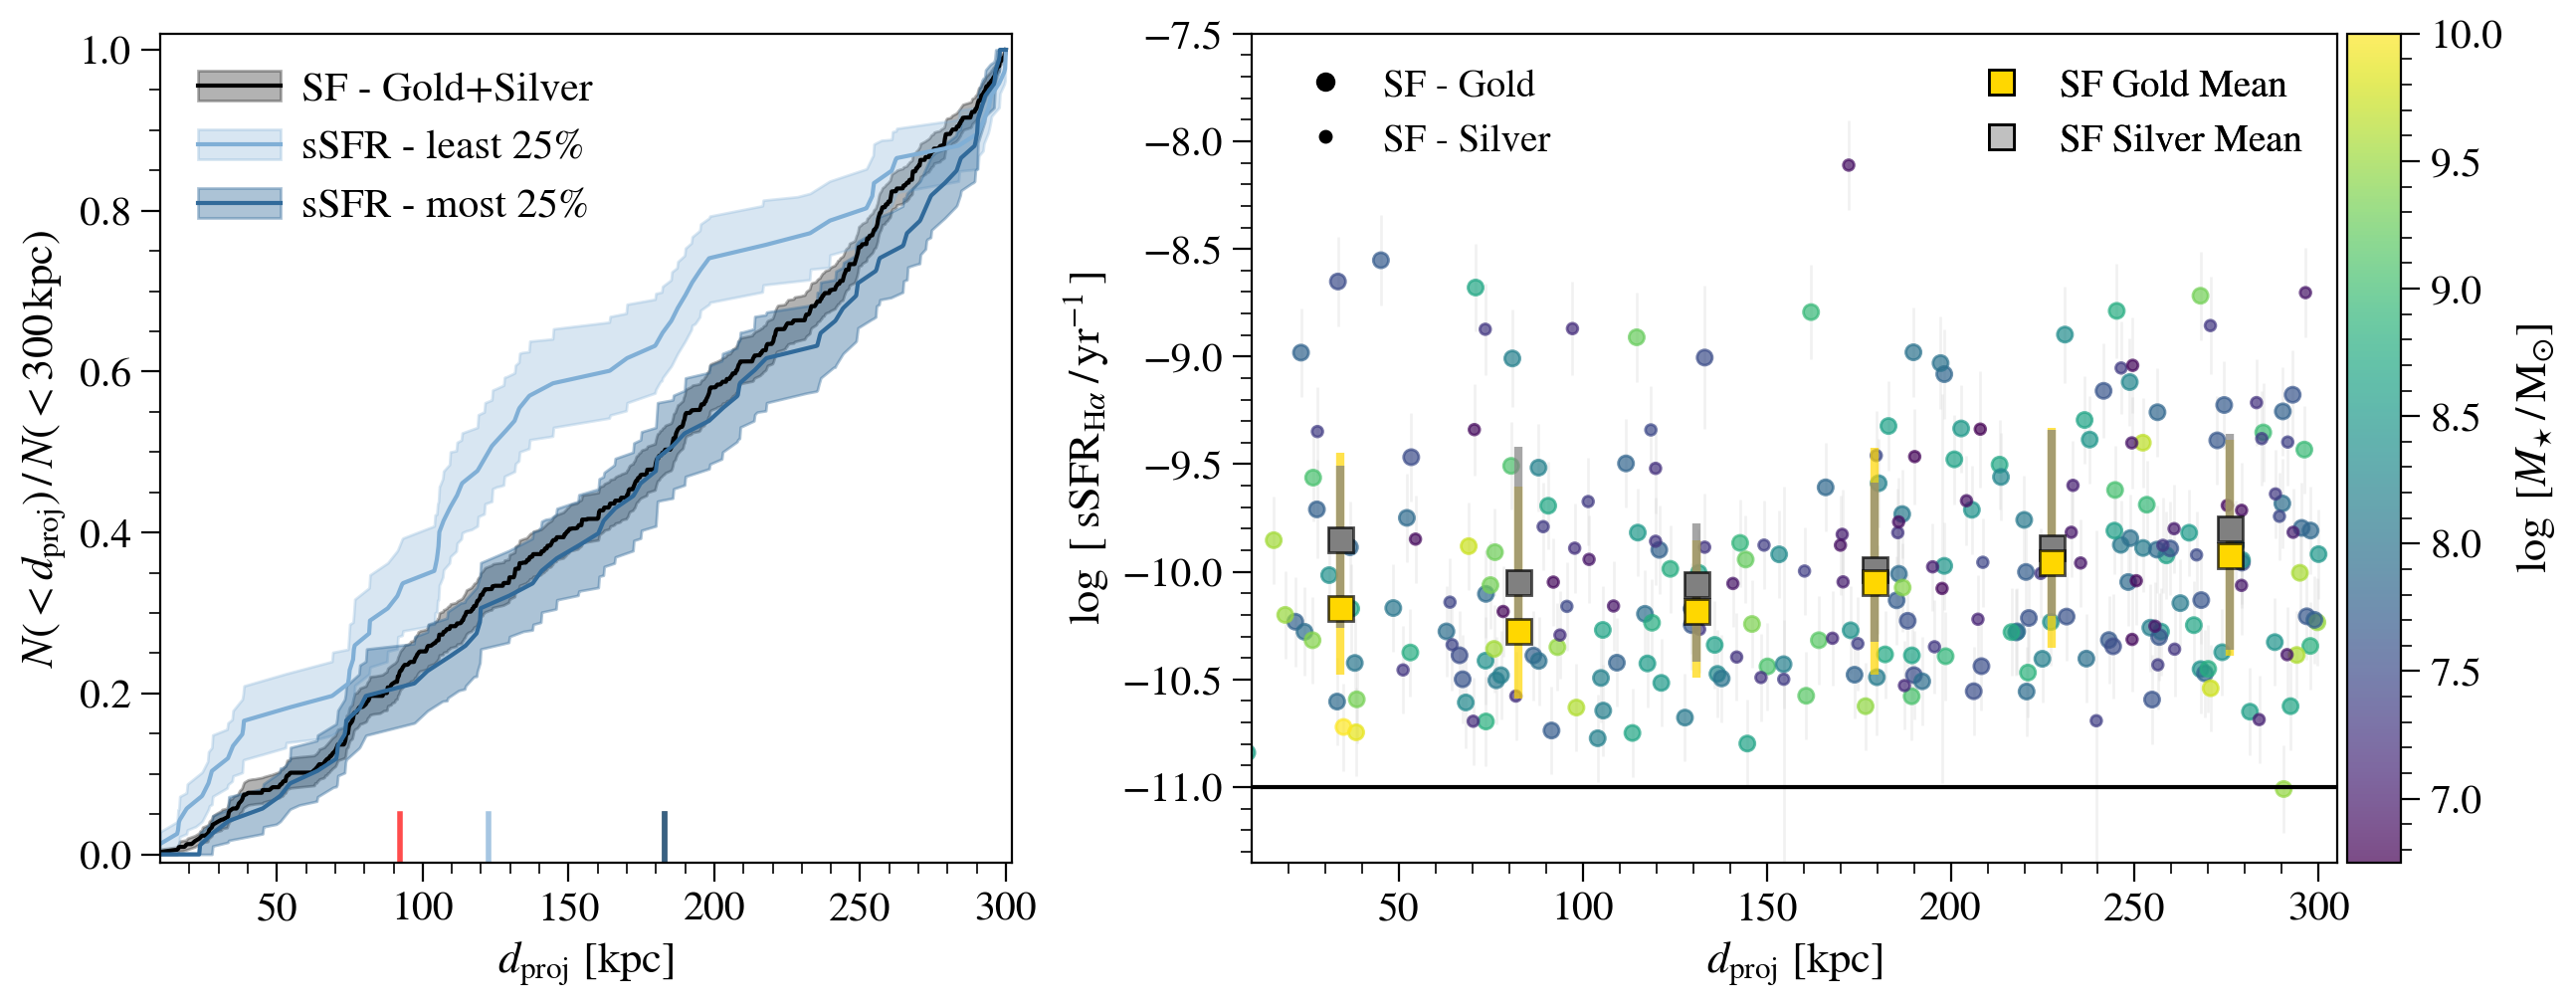

In [12]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_sf_radial.pdf')
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=get_figsize(wide=True, ratio=2.5),gridspec_kw={'width_ratios': [1, 1.35]})


tsf = Query(C.sample_gold, star_forming_selector).filter(base, ["RHOST_KPC", "p_sat_corrected",'Halpha_sfr','nuv_sfr','log_sm','nuv_mag_flag','EW_Halpha','quenched'])


# PLOT DETECTED
m = (tsf['p_sat_corrected']==1) & (tsf['EW_Halpha'] > 2)& (tsf['quenched'] == 0)
cm=ax2.scatter(tsf['RHOST_KPC'][m],tsf['Halpha_sfr'][m]-tsf['log_sm'][m],\
        c=tsf['log_sm'][m],vmin=6.75,vmax=10,s=30,\
            alpha=0.7, rasterized=True,marker = 'o',label='SF')
tsf=tsf[m]


# Make an axis for the colorbar on the right side
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(cm, cax=cax,label=r'$\log~[M_{\star}\,/\,{\rm M}_{\odot}]$')



##############
# ADD GOLD+SILVER MEDIAN?
tsf_silver = Query((C.sample_silver), star_forming_selector).filter(base, ["RHOST_KPC", "p_sat_corrected",'Halpha_sfr','Halpha_sfr_err','log_sm','nuv_sfr','nuv_mag_flag','EW_Halpha','quenched'])
m = (tsf_silver['p_sat_corrected']==1) & (tsf_silver['EW_Halpha'] > 2)& (tsf_silver['quenched'] == 0)
tsf_silver=tsf_silver[m]

ax2.scatter(tsf_silver['RHOST_KPC'],tsf_silver['Halpha_sfr']-tsf_silver['log_sm'],\
        c=tsf_silver['log_sm'],vmin=6.75,vmax=10,\
            alpha=0.7, rasterized=True,marker = 'o',label='SF',s=15)


tsf = Query((C.sample_gold | C.sample_silver), star_forming_selector).filter(base, ["RHOST_KPC", "p_sat_corrected",'Halpha_sfr','nuv_sfr','log_sm','Halpha_sfr_err','nuv_mag_flag','EW_Halpha','quenched'])
m = (tsf['p_sat_corrected']==1) & (tsf['EW_Halpha'] > 2)& (tsf['quenched'] == 0)
ssf_err = np.sqrt(tsf['Halpha_sfr_err']**2 + 0.2**2)
ax2.errorbar(tsf['RHOST_KPC'][m],tsf['Halpha_sfr'][m]-tsf['log_sm'][m],fmt='None',yerr=ssf_err[m],c='lightgrey',alpha=0.3,zorder=0,lw=1)


# MEAN BINS
rbins = np.linspace(10, 300, 7)
xd = 0.5 * (rbins[1:] + rbins[:-1])

silver_ssfr     = tsf_silver['Halpha_sfr']-tsf_silver['log_sm']
silver_ssfr_err = np.sqrt(tsf_silver['Halpha_sfr_err']**2 + 0.2**2)
silver_r        = tsf_silver['RHOST_KPC']

sa,sb,sc = bin_wmean(rbins,silver_r,silver_ssfr,silver_ssfr_err)

color='grey'
ax2.plot(xd,sa,'s',c=color,ms=8)
ax2.errorbar(xd,sa,yerr=[sb,sc],ls='none',c=color,ms=8,alpha=0.7,lw=3)
ax2.plot(xd,sa,'s',c='k',ms=9,alpha=0.7,mfc='none')


gold_ssfr=tsf['Halpha_sfr']-tsf['log_sm']
gold_ssfr_err = np.sqrt(tsf['Halpha_sfr_err']**2 + 0.2**2)
gold_r   =tsf['RHOST_KPC']

ga,gb,gc = bin_wmean(rbins,gold_r,gold_ssfr,gold_ssfr_err)

color='gold'
ax2.plot(xd,ga,'s',c=color,ms=8)
ax2.errorbar(xd,ga,yerr=[gb,gc],ls='none',c=color,ms=8,alpha=0.7,lw=3,zorder=1)
ax2.plot(xd,ga,'s',c='k',ms=9,alpha=0.7,mfc='none')

np.save("data/ssfr_dist.npy", np.vstack([xd, sa,sb,sc, ga,gb,gc]))  # for table printing

#########################

# DATA LEGEND
l1 = mlines.Line2D([], [], color='k', marker='o', ls='', label='SF - Gold',ms=6)
l2 = mlines.Line2D([], [], color='k', marker='o', ls='', label='SF - Silver',ms=4)
l4 = mlines.Line2D([], [], mfc='gold',marker='s',ls='', label='SF Gold Mean',ms=9,c='k')
l5 = mlines.Line2D([], [], mfc='silver',marker='s',ls='', label='SF Silver Mean',ms=9,c='k')



leg1 = ax2.legend(fontsize=14,loc='upper left',handles=[l1,l2])
leg2 = ax2.legend(fontsize=14,loc='upper right',handles=[l4,l5])
ax2.add_artist(leg1)
ax2.add_artist(leg2)


ax2.set_xlabel(r"$d_{\rm proj}$ [kpc]")
ax1.set_xlabel(r"$d_{\rm proj}$ [kpc]")

#ax2.set_ylabel(r'sSFR$_{{\rm H}\alpha}~[{\rm yr}^{-1}$]')
ax2.set_ylabel(r'$\log~[\;{\rm sSFR}_{{\rm H}\alpha} \: / \, {\rm yr}{^{-1}}\,$]')


ax2.set_xlim(10,305)
ax2.set_ylim(-11.35,-7.5)
ax2.axhline(-11,c='k')



######################
# RADIAL HISTOGRAMS
#cdf_rbins = np.linspace(10, 300, 7)

sf,=ax1.plot(cdf_rbins, radial_plain, c="k",label='SF - gold')
sfr=ax1.fill_between(cdf_rbins, radial_boot16, radial_boot84, color="k", alpha=0.3)

lsf1, = ax1.plot(cdf_rbins, radial_plain_1, c="#80afd6",label='sSFR - least 25%')
lsfr1 = ax1.fill_between(cdf_rbins, radial_boot16_1, radial_boot84_1, color="#80afd6", alpha=0.3)

lsf2, = ax1.plot(cdf_rbins, radial_plain_4, c="#316a9a",label=r'sSFR - most 25%')
lsfr2 = ax1.fill_between(cdf_rbins, radial_boot16_4, radial_boot84_4, color="#316a9a", alpha=0.4)


ax1.plot([sf1_half,sf1_half],[-0.01,0.05],lw=2, c="#80afd6",alpha=0.7)
ax1.plot([sf_half,sf_half],[-0.01,0.05],lw=2, c="k",alpha=0.7)
ax1.plot([sf4_half,sf4_half],[-0.01,0.05],lw=2, c="#316a9a",alpha=0.7)

q_half=92.1
ax1.plot([q_half,q_half],[-0.01,0.05],lw=2,c='r',alpha=0.7)


ax1.legend([(sf,sfr),(lsf1,lsfr1),(lsf2,lsfr2)],\
           ['SF - Gold+Silver',r'sSFR - least 25%',\
            r'sSFR - most 25%'],loc='upper left')


ax1.set_ylabel(r"$N(<d_{\rm proj})\,/\,N(<300\,{\rm kpc})$")
ax1.set_xlabel(r"$d_{\rm proj}$ [kpc]")

ax1.set_ylim(-0.01,1.02)
ax1.set_xlim(10,302)

try:
    pdf.savefig()
    pdf.close()
except NameError:
    pass

In [13]:
print('all sf half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf_half,sf_half16-sf_half,sf_half-sf_half84))
print()

print('sf1 half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf1_half,sf1_half16-sf1_half,sf1_half-sf1_half84))
print('sf2 half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf2_half,sf2_half16-sf2_half,sf2_half-sf2_half84))
print('sf3 half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf3_half,sf3_half16-sf3_half,sf3_half-sf3_half84))
print('sf4 half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf4_half,sf4_half16-sf4_half,sf4_half-sf4_half84))

print()
print('sf1 half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf1_half,sf1_half16,sf1_half84))
print('sf4 half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf4_half,sf4_half16,sf4_half84))


all sf half = 182.8  4.9  8.1

sf1 half = 122.5  10.7  13.0
sf2 half = 183.1  13.3  15.1
sf3 half = 204.3  16.8  14.8
sf4 half = 183.1  19.7  11.0

sf1 half = 122.5  133.2  109.5
sf4 half = 183.1  202.8  172.1


## Generate binned table data

In [14]:
print('Gold Median')
print('rbin    sSFR   sSFR_lerr   sSFR_herr')
for r,a,b,c in zip(xd,ga,gb,gc):
    print('{:0.1f}\t  {:0.2f}\t  {:0.2f}\t  {:0.2f}'.format(r, a,b,c))
    
print()
print('Silver Median')
print('rbin    sSFR   sSFR_lerr   sSFR_herr')
for r,a,b,c in zip(xd,sa,sb,sc):
    print('{:0.1f}\t  {:0.2f}\t  {:0.2f}\t  {:0.2f}'.format(r, a,b,c))

Gold Median
rbin    sSFR   sSFR_lerr   sSFR_herr
34.2	  -10.17	  0.31	  0.72
82.5	  -10.27	  0.32	  0.67
130.8	  -10.18	  0.31	  0.33
179.2	  -10.05	  0.43	  0.62
227.5	  -9.96	  0.40	  0.63
275.8	  -9.92	  0.47	  0.53

Silver Median
rbin    sSFR   sSFR_lerr   sSFR_herr
34.2	  -9.85	  0.41	  0.34
82.5	  -10.05	  0.28	  0.63
130.8	  -10.06	  0.36	  0.28
179.2	  -9.99	  0.34	  0.40
227.5	  -9.89	  0.32	  0.54
275.8	  -9.80	  0.56	  0.44
